# Getting Courses
---

Set username and password if you want to login automatically. Not required.

In [1]:
USERNAME = ""
PASSWORD = ""

Log into temple and wait for the request session to be created.

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec
import requests
import json

# Urls that get information about courses and terms
URL_TERMS = "https://prd-xereg.temple.edu/StudentRegistrationSsb/ssb/plan/getTerms"
URL_COURSE_INFO = "https://prd-xereg.temple.edu/StudentRegistrationSsb/ssb/searchResults/searchResults"

# Post urls that are required to getting new information
URL_PLAN_MODE = "https://prd-xereg.temple.edu/StudentRegistrationSsb/ssb/term/search?mode=plan"
URL_RESET_DATAFORM = "https://prd-xereg.temple.edu/StudentRegistrationSsb/ssb/courseSearch/resetDataForm"

# Pages that you are required to visit (otherwise you cannot search for courses)
URL_PAGE_LOGIN = "https://tuportal.temple.edu"
URL_PAGE_HOME = "https://tuportal6.temple.edu/group/home"
URL_PAGE_REGISTRATION = "https://prd-xereg.temple.edu/StudentRegistrationSsb/ssb/registration"


try:
    # Initialize browser and redirect to login page
    print("Initializing browser and redirecting to temple login page.")
    driver = webdriver.Chrome()
    driver.maximize_window()
    driver.get(URL_PAGE_LOGIN)
    driver_wait = WebDriverWait(driver, 10)

    # Fill out username and password if specified
    try:
        if len(USERNAME) > 0 and len(PASSWORD) > 0:
            print("Attempting to login automatically.")
            username_field = driver_wait.until(ec.presence_of_element_located((By.ID, "username")))
            password_field = driver_wait.until(ec.presence_of_element_located((By.ID, "password")))
            username_field.send_keys(USERNAME)
            password_field.send_keys(PASSWORD)
            login_button = driver.find_element(By.CLASS_NAME, "btn-login")
            login_button.click()
    except NameError:
        print("Username and password not defined, waiting for manual login.")
        pass

    # Detect if user has finished logging in (auto accepts trust browser)
    def finish_login(driver):
        if button := driver.find_elements(By.ID, "trust-browser-button"):
            button[0].click()
        return driver.current_url == URL_PAGE_HOME

    # Redirect to self service banner page once logged in (5 minutes max to login)
    WebDriverWait(driver, 5 * 60).until(finish_login)
    print("Login complete, redirecting to registration page.")
    driver.get(URL_PAGE_REGISTRATION)

    # Click planning link once it is available
    print("Redirecting to planning page.")
    link = driver_wait.until(ec.element_to_be_clickable((By.ID, "planningLink")))
    link.click()

    # Grab required cookies from current session (required for future requests)
    print("Grabbing required session information.")
    session = requests.Session()
    session.cookies.update(
        {
            "JSESSIONID": driver.get_cookie("JSESSIONID")["value"],
            "BIGipServerprd_xereg_8180_pool": driver.get_cookie("BIGipServerprd_xereg_8180_pool")["value"],
        }
    )
    # print(json.dumps({cookie["name"]: cookie["value"] for cookie in driver.get_cookies()}, indent=4))

    # The browser is no longer required after the session is created
    print("Session created, exiting browser.")
    driver.quit()
except Exception as error:
    print("Failed to create session:", error)


def fetch(url: str, query_params):
    try:
        response = session.get(url, params=query_params)

        if response.status_code != 200:
            return False, f"Failed to retrieve the page. Status code: {response.status_code}"
        return True, response.json()
    except ValueError:
        return False, "You are not logged in."
    except Exception as error:
        return False, error.with_traceback()


def fetch_recursive(url: str, query_params, *, filter=None, output=False):
    query_params["pageOffset"] = 0
    query_params["pageMaxSize"] = 2000
    data = []

    while True:
        success, result = fetch(url, query_params)
        if not success:
            return success, result
        if not result["success"] or not result["data"]:
            return False, "Fetch failed. Data not found."

        if filter:
            # only append values filtered values
            data.extend(value for item in result["data"] if (value := filter(item)))
        else:
            # appened all results
            data.extend(result["data"])

        # update page offset by length of the data
        query_params["pageOffset"] += len(result["data"])

        if output:
            print(f"Fetched data ({query_params["pageOffset"]} out of {result["totalCount"]}).")

        if query_params["pageOffset"] >= result["totalCount"]:
            break
    return True, data

Once the session has been created, execute the cell below to get the code for the term you are planning course for.

In [20]:
success, result = fetch(URL_TERMS, {"offset": 0, "max": 3})

if not success:
    print("Error getting term codes:", result)
else:
    for term in result:
        print(f"CODE: {term["code"]}, TITLE: {term["description"]}")

CODE: 202503, TITLE: 2025 Spring
CODE: 202436, TITLE: 2024 Fall
CODE: 202426, TITLE: 2024 Summer II


Once you have retrieved the term code, update the `TERM_CODE` variable with the code and specify which courses you are planning to take.

In [4]:
TERM_CODE = 202503

In [21]:
from dateutil import parser
from datetime import datetime


class Meeting:
    days: list[str]
    begin: datetime
    end: datetime

    def __init__(self, meeting: dict[str, any]) -> None:
        COURSE_DAYS = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
        self.days = [day for day in COURSE_DAYS if meeting[day]]
        self.begin = parser.parse(meeting["beginTime"][:2] + ":" + meeting["beginTime"][2:])
        self.end = parser.parse(meeting["endTime"][:2] + ":" + meeting["endTime"][2:])


class Course:
    title: str
    section: str
    meetings: list[Meeting]

    def __init__(self, course: dict[str, any]) -> None:
        self.title = course["courseTitle"]
        self.section = course["sequenceNumber"]
        self.meetings = []

        for meeting in course["meetingsFaculty"]:
            self.meetings.append(Meeting(meeting["meetingTime"]))

    def __str__(self) -> str:
        return self.title


def get_course_info(courses: list[str]) -> dict[str, list[Course]]:
    def filter_section(course: dict[str, any]):
        if course["campusDescription"] == "Main" and course["instructionalMethod"] == "CLAS":
            return course
        return None

    classes = {}
    for course in set(courses):
        classes[course] = []

        # Refresh courses and sections (otherwise the server will cache the results)
        session.post(URL_PLAN_MODE, data={"term": TERM_CODE})
        session.post(URL_RESET_DATAFORM, data={"resetCourses": True, "resetSections": True})

        # Get course info
        success, result = fetch_recursive(
            URL_COURSE_INFO,
            {
                "txt_subjectcoursecombo": course,
                "txt_term": TERM_CODE,
            },
            filter=filter_section,
        )

        if success:
            for course_details in result:
                classes[course].append(Course(course_details))

        # print(course)
        # if not success:
        #     print("  ", result)
        # else:
        #     for course in result:
        #         a = Course(course)
        #         print("  ", a.title, a.section)
        #         for meeting in a.meetings:
        #             print("    ", meeting.days)
        #             print("    ", meeting.begin)
        #             print("    ", meeting.end)
        # print(json.dumps(result, indent=4))
    return classes


courses: dict[str, list[Course]] = get_course_info(["MATH2043", "CIS2033", "IH0851", "MATH2101", "CIS1068"])
# courses: dict[str, list[Course]] = get_course_info(["CIS1057", "CIS1166", "ENG0802", "CIS1001", "SCTC1001"])

# Plotting Courses
---

In [ ]:
from itertools import product

class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        # if isinstance(obj, Meeting):
        #     return {
        #         "days": obj.days,
        #         "begin": obj.begin.isoformat(),
        #         "end": obj.end.isoformat(),
        #     }
        # if isinstance(obj, Course):
        #     return {
        #         "title": obj.title,
        #         "section": obj.section,
        #         # "meetings": obj.meetings,
        #     }
        if isinstance(obj, Course):
            return f"""Course{{'title': {obj.title}, 'section': {obj.section}}}"""
        return super().default(obj)

cartesian_product_courses = list(product(*[a for a in courses.values()]))

print(json.dumps(cartesian_product_courses, cls=CustomEncoder, indent=4))

5
WEEK_RANGE: 5.33 hrs, WEEK_TOTAL: 18.17 hrs, BREAK_TOTAL: 2.83 hrs


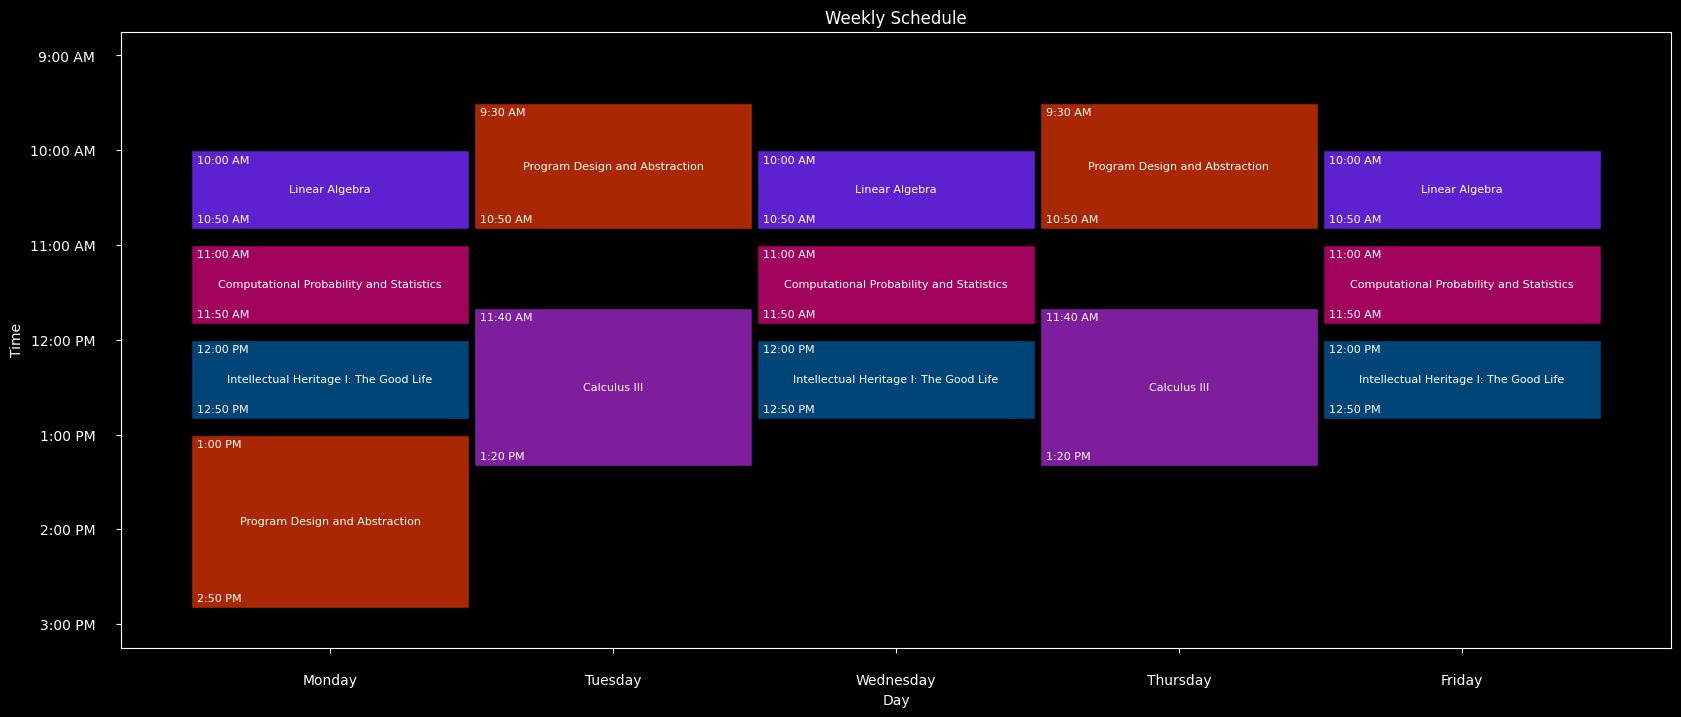

WEEK_RANGE: 5.83 hrs, WEEK_TOTAL: 19.17 hrs, BREAK_TOTAL: 3.83 hrs


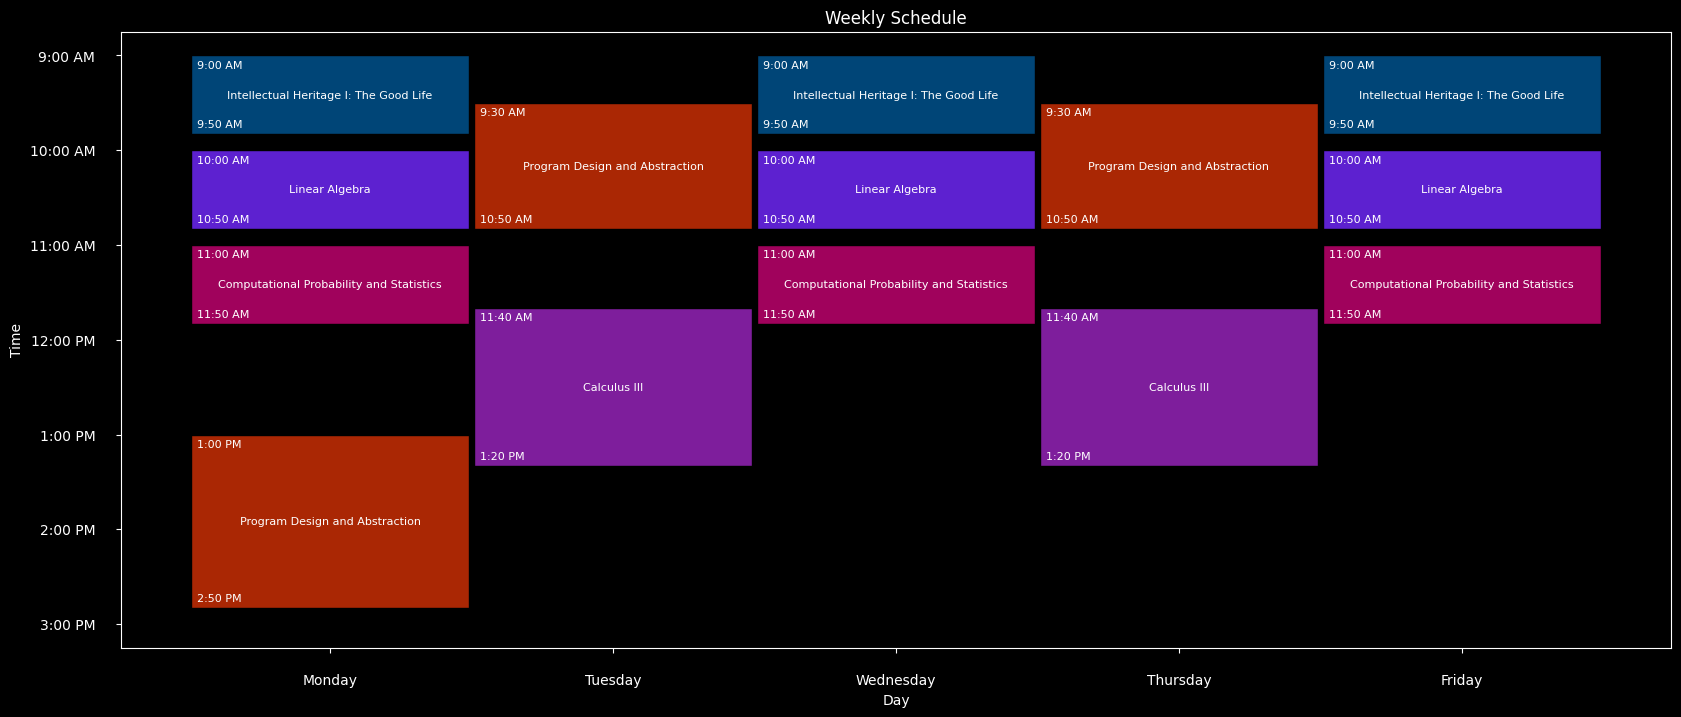

WEEK_RANGE: 5.83 hrs, WEEK_TOTAL: 20.17 hrs, BREAK_TOTAL: 4.67 hrs


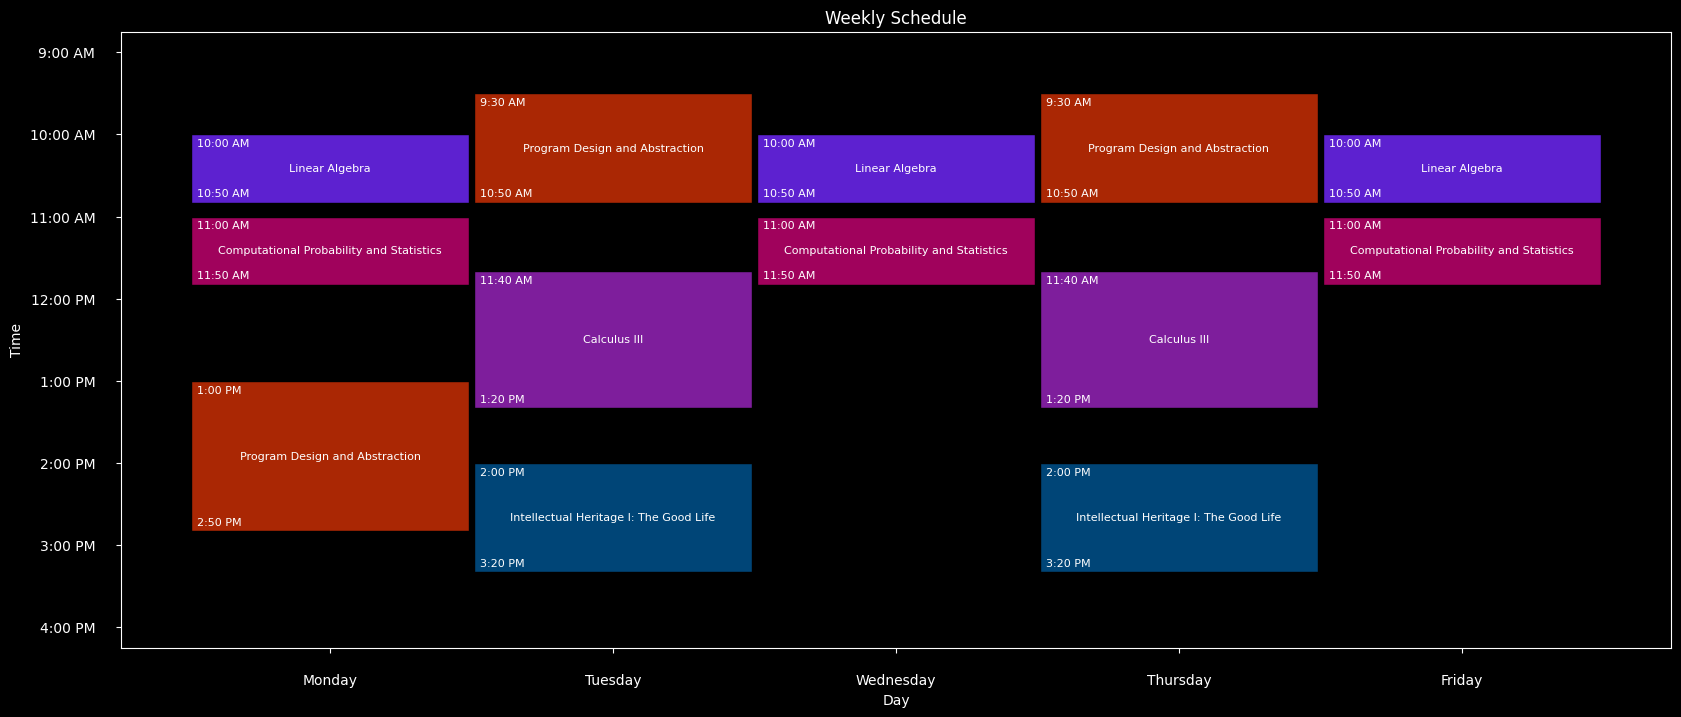

WEEK_RANGE: 5.33 hrs, WEEK_TOTAL: 22.17 hrs, BREAK_TOTAL: 6.83 hrs


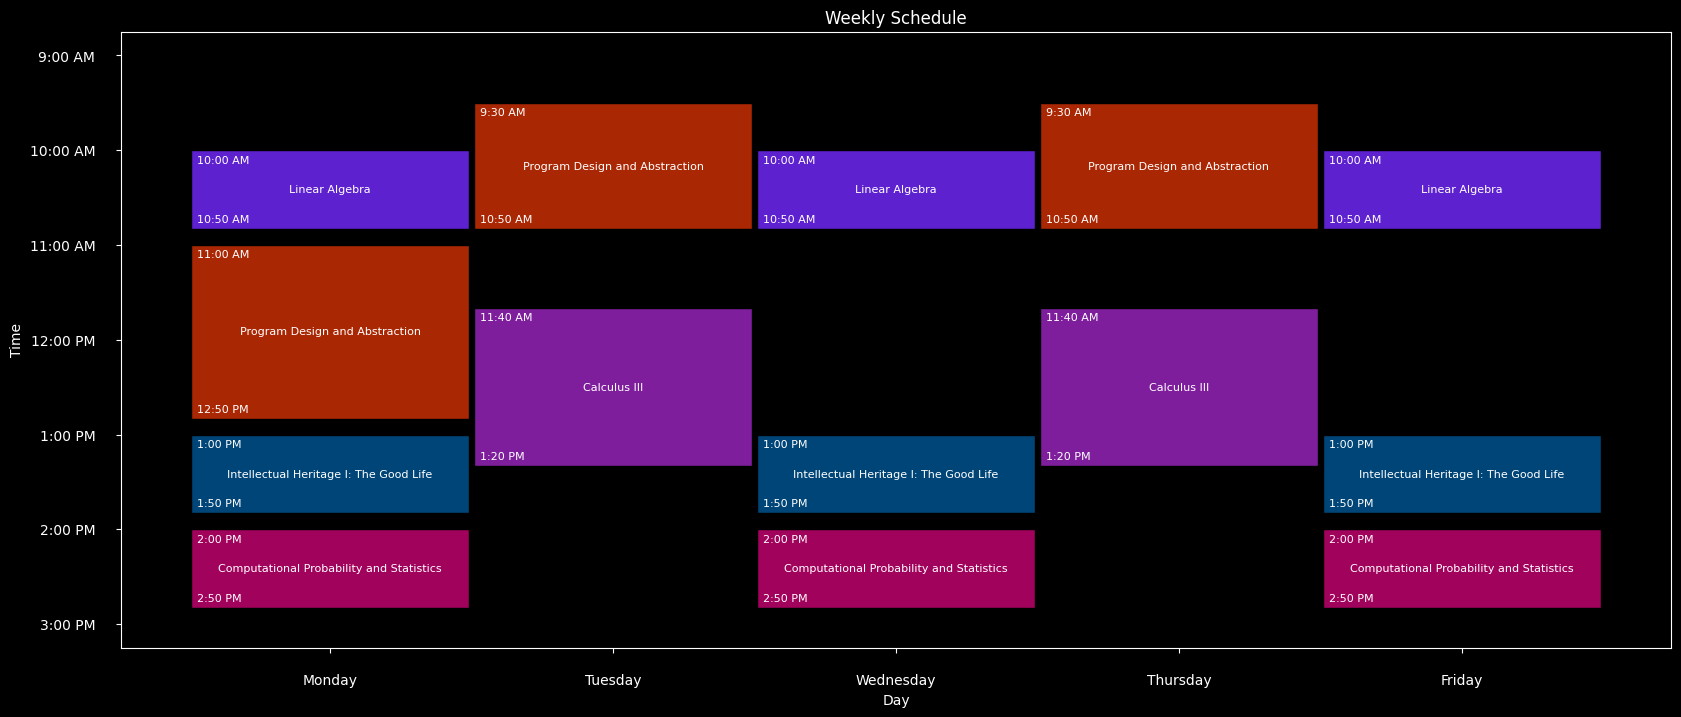

WEEK_RANGE: 5.33 hrs, WEEK_TOTAL: 22.17 hrs, BREAK_TOTAL: 6.83 hrs


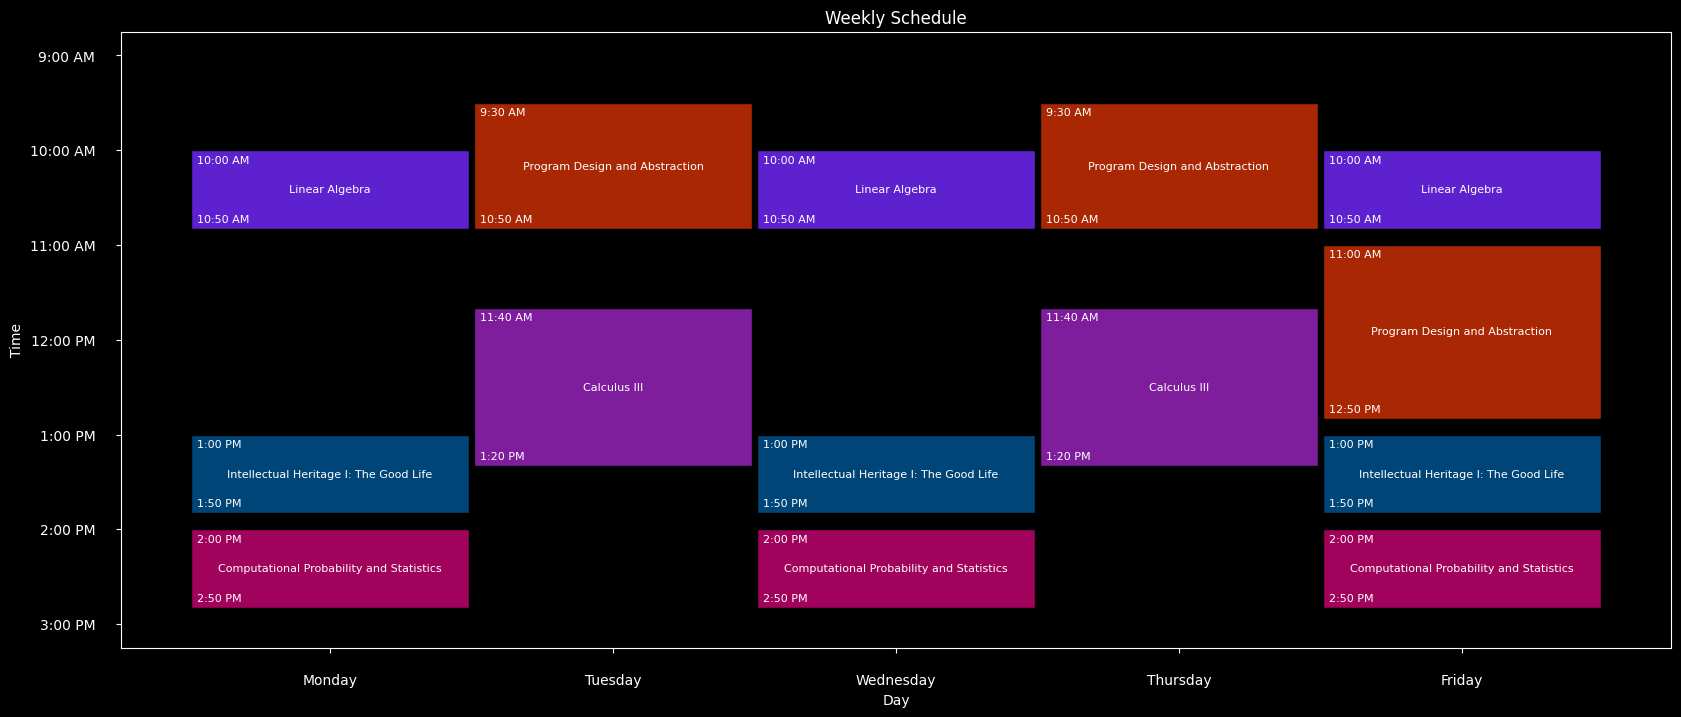

In [41]:
from datetime import datetime
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import math
import random


class Event:
    """Class representing an event in the schedule."""

    def __init__(self, name: str, day: str, time_begin: datetime, time_end: datetime):
        days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
        self.name: str = name
        self.day: float = days.index(day.lower())
        self.begin: datetime = time_begin
        self.end: datetime = time_end

    def __eq__(self, other: object) -> bool:
        return self.name == other.name and self.day == other.day and self.begin == other.begin and self.end == other.end

    def __hash__(self):
        return hash((self.name, self.day, self.begin, self.end))


class Schedule:
    """Class representing a schedule containing multiple events."""

    def __init__(self, schedule: list[Course]):
        self.events: list[Event] = []
        self.add_schedule(schedule)

    def __eq__(self, other: object) -> bool:
        return self.events == other.events

    def __hash__(self):
        return hash(tuple(self.events))

    def add_schedule(self, courses: list[Course]):
        """Adds events to the schedule from a list of courses."""
        for course in courses:
            for meeting in course.meetings:
                for day in meeting.days:
                    self.add_event(course.title, day, meeting.begin, meeting.end)

    def add_event(self, name: str, day: str, time_begin: datetime, time_end: datetime):
        """Adds a new event to the schedule."""
        self.events.append(Event(name, day, time_begin, time_end))

    def has_overlap(self) -> bool:
        """Checks if any events overlap within the schedule."""

        # Group events by day to check overlaps within each day
        events_by_day = {}
        for event in self.events:
            events_by_day.setdefault(event.day, []).append(event)

        # Check for overlaps within each day
        for events in events_by_day.values():
            events.sort(key=lambda e: e.begin)  # Sort by start time
            for i in range(1, len(events)):
                if events[i - 1].end > events[i].begin:  # Overlap detected
                    return True
        return False

    def get_formatted_time(self, hour: int) -> str:
        """Returns a formatted time string in AM/PM format."""
        label = "PM" if 12 <= hour < 24 else "AM"
        hour = hour % 12 or 12  # Convert 0 to 12 for midnight
        return f"{hour}:00 {label}"

    def get_dark_mode_colors(self) -> list:
        """Generates a list of suitable colors for dark mode from XKCD colors."""
        dark_mode_colors = []
        for color_name in mcolors.XKCD_COLORS:
            r, g, b = mcolors.to_rgb(mcolors.XKCD_COLORS[color_name])
            luminance = (r * 0.299 + g * 0.587 + b * 0.114) * 255
            if 50 <= luminance <= 80:
                dark_mode_colors.append(mcolors.XKCD_COLORS[color_name])

        dark_mode_colors.sort()
        random.seed(2024)
        random.shuffle(dark_mode_colors)
        return dark_mode_colors

    def get_range(self) -> tuple[float, float]:
        """Returns the minimum and maximum times of events in the schedule."""
        time_min = 24
        time_max = 0

        for event in self.events:
            time_min = min(time_min, event.begin.hour + event.begin.minute / 60)
            time_max = max(time_max, event.end.hour + event.end.minute / 60)
        return time_min, time_max

    def get_schedule_time(self, time: datetime) -> float:
        """Converts a datetime object to a float representing hours left in the day."""
        return 24 - (time.hour + time.minute / 60)

    def show(self):
        """Displays the weekly schedule using matplotlib."""
        plt.figure(figsize=(20, 8))

        days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        # times = ["{0}:00".format(hour) for hour in range(24, -1, -1)]
        times = [self.get_formatted_time(hour) for hour in range(24, -1, -1)]

        plt.xticks(np.arange(len(days)), days)
        plt.yticks(np.arange(len(times)), times)
        plt.ylabel("Time")
        plt.xlabel("Day")
        plt.title("Weekly Schedule")
        plt.style.use("dark_background")
        plt.tick_params(axis="both", which="major", pad=15)

        dark_mode_colors = self.get_dark_mode_colors()
        event_colors: dict[str, any] = {}

        if len(self.events) > 0:
            range_min, range_max = self.get_range()
            range_min = 24 - math.floor(range_min) + 0.25
            range_max = 24 - math.ceil(range_max) - 0.25
            plt.ylim(range_max, range_min)
            # plt.ylim(0, 24)

            CELL_WIDTH = 0.98

            for event in self.events:
                beg: float = self.get_schedule_time(event.begin)
                end: float = self.get_schedule_time(event.end)

                if event.name not in event_colors:
                    event_colors[event.name] = dark_mode_colors.pop(0)

                plt.bar(
                    event.day,
                    height=(end - beg),
                    bottom=beg,
                    width=CELL_WIDTH,
                    color=event_colors[event.name],
                    edgecolor="black",
                )
                plt.text(event.day, (beg + end) / 2, event.name, ha="center", va="center", fontsize=8)

                def to_hm(time: datetime):
                    label = "PM" if 12 <= time.hour < 24 else "AM"
                    return "{0}:{1:0>2} {2}".format(time.hour % 12 or 12, time.minute, label)

                plt.text(
                    event.day - CELL_WIDTH / 2 + 0.02, beg - 0.05, to_hm(event.begin), ha="left", va="top", fontsize=8
                )
                plt.text(
                    event.day - CELL_WIDTH / 2 + 0.02, end + 0.05, to_hm(event.end), ha="left", va="bottom", fontsize=8
                )
        plt.show()


class ScheduleCompare:
    def not_overlap(s: Schedule):
        return not s.has_overlap()

    def week_range(s: Schedule):
        min, max = s.get_range()
        return max - min

    def week_total(s: Schedule):
        events_by_day = {}
        for event in s.events:
            events_by_day.setdefault(event.day, []).append(event)

        total_time = 0
        for events in events_by_day.values():
            events.sort(key=lambda e: e.begin)
            prev_time = events[0].begin.hour + events[0].begin.minute / 60
            curr_time = events[-1].end.hour + events[-1].end.minute / 60
            total_time += curr_time - prev_time
        return total_time

    def between_total(s: Schedule):
        events_by_day = {}
        for event in s.events:
            events_by_day.setdefault(event.day, []).append(event)

        total_time = 0
        for events in events_by_day.values():
            events.sort(key=lambda e: e.begin)
            for i in range(1, len(events)):
                prev_time = events[i - 1].end.hour + events[i - 1].end.minute / 60
                curr_time = events[i].begin.hour + events[i].begin.minute / 60
                total_time += curr_time - prev_time
        return total_time


schedules = [Schedule(schedule) for schedule in cartesian_product_courses]
schedules = list(filter(ScheduleCompare.not_overlap, schedules))
schedules = sorted(schedules, key=ScheduleCompare.between_total)
schedules = {schedule: True for schedule in schedules}
schedules = list(schedules.keys())[:5]

print(len(schedules))

for schedule in schedules:
    print(
        f"WEEK_RANGE: {ScheduleCompare.week_range(schedule):.2f} hrs, "
        f"WEEK_TOTAL: {ScheduleCompare.week_total(schedule):.2f} hrs, "
        f"BREAK_TOTAL: {ScheduleCompare.between_total(schedule):.2f} hrs"
    )
    schedule.show()
    # break